# Separation des sources

Application des méthodes classiques pour la **séparation / localisation des sources** en utilisant la bibliothèque **scikit learn**.

Méthodes à être appliquées : 
- **NMF** (Non-negative Matrix Factorization)
- **ICA** (Independent Component Analysis)
- **SCA** (Sparse Component Analysis)

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

## ICA (Independent Component Analysis)

### Example from scikit learn: BSS (Blind Source Separation) using FastICA

An example of **estimating sources from noisy data**.

Independent component analysis (ICA) is used to estimate sources given noisy measurements. Imagine 3 instruments playing simultaneously and 3 microphones recording the mixed signals. ICA is used to recover the sources ie. what is played by each instrument.

Automatically created module for IPython interactive environment

X shape: (2000, 3)

Mixing matrix A:
 [[1.  1.  1. ]
 [0.5 2.  1. ]
 [1.5 1.  2. ]]

Estimated mixing matrix:
 [[-46.02147955  42.50809743  45.32804372]
 [-44.05919471  21.19031463  88.65606826]
 [-91.72748329  61.75542772  44.5776646 ]]

Estimated mixing matrix shape: (3, 3)

S shape: (2000, 3)

S_ shape: (2000, 3)


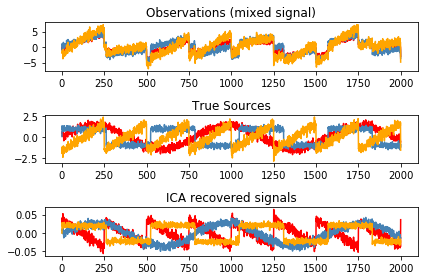

Wall time: 32.4 s


In [2]:
%%time

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from sklearn.decomposition import FastICA

# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# #############################################################################
# Plot results
print('\nX shape:', X.shape)
print('\nMixing matrix A:\n', A)
print('\nEstimated mixing matrix:\n', A_)
print('\nEstimated mixing matrix shape:', A_.shape)
print('\nS shape:', S.shape)
print('\nS_ shape:', S_.shape)
plt.figure()

models = [X, S, S_]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(3, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

Recovered signals:


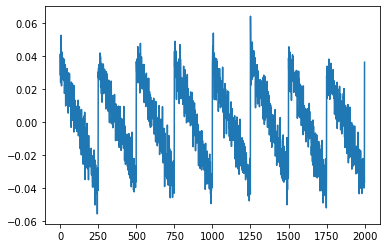

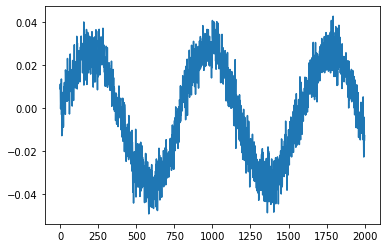

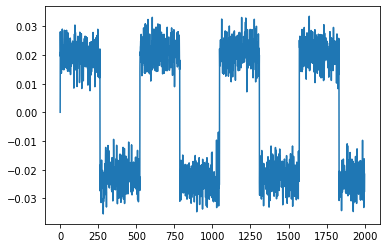

In [3]:
print('Recovered signals:')
dim = S_.shape

for i in range(dim[1]):
    plt.plot(S_[:, i])
    plt.show()

## Image separation - Linear and overdertermined mixture - ICA and NMF

In the test, we have **1000 images** that are combinations of the four handwritten numbers **0, 1, 4, 7,** with varying ratios. We want to recover the source images from the mixed images.

In the situation we have the **prior information** about the **number of sources** (4 sources) and we can considere our **mixture** as **linear** and **overdetermined** because we have more observations, samples (1000) than sources (4).

To apply **ICA** the mixed signals must be a **linear combination** of sources signals. The ICA assumes that the sources signals are **independent** and **non-Gaussian**.

Like ICA, **NMF** also aims to decompose the mixed data X into a product of matrices **WH = X**, but here there is the added constraint that **each matrix X, W, H are nonnegative**.

Reference: https://towardsdatascience.com/step-by-step-signal-processing-with-machine-learning-pca-ica-nmf-8de2f375c422

In [4]:
import glob
import cv2
import numpy as np
import source_separation as ss
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.decomposition import SparsePCA

def main():
    
    images = []
    for path in glob.glob("mixture_dataset(0147)/*.jpg"):
        images.append(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY))
    
    # Limit the number of samples
    lim = 1000
    images = images[:lim]
        
    print('The first figure is an example of mixture.\n')
    plt.figure()
    plt.imshow(images[0], cmap = 'gray')

    # Reshape images to 1D arrays
    flat_images = np.array(images).reshape(len(images), -1)
    
    X = flat_images
    print('X (Observations): ' + str(X.shape))
    
    #option = "ICA" # ICA, NMF, SparsePCA 
    option = "NMF"
    #option = "SparcePCA"
    
    if (option == 'ICA'):
        
        # ICA implemented by scikit learn
        
        ica_model = FastICA(n_components = 4, tol = 1e-8, max_iter = 10000)
        ica_model.fit(X)

        A_ = ica_model.mixing_ # (n_features, n_components)

        A_t = A_.transpose().reshape(-1, 28, 28)
        print('Sources separated: ' + str(A_t.shape))

        for i, im in enumerate(A_t):
            cv2.imwrite("output/ica_{}.jpg".format(i), im)

        dim = A_t.shape

        print('Printing sources separated by using ICA.')
        for i in range(int(dim[0])):
            plt.figure()
            plt.imshow(A_t[i][:][:], cmap = 'gray')
            plt.show()

        print('\nDone!\n')

    elif (option == 'NMF'):
        
        # NMF implemented by scikit learn

        nmf_model = NMF(n_components = 4, tol = 1e-8, max_iter = 10000)
        nmf_model.fit(X)

        H_ = nmf_model.components_ # (n_componets, n_features)
        H_2 = H_.reshape(-1, 28, 28)
        print('Sources separated: ' + str(H_2.shape))

        for i, im in enumerate(H_2):
            cv2.imwrite("output/nmf_{}.jpg".format(i), im)

        dim = H_2.shape

        print('Printing sources separated by using NMF.')
        for i in range(int(dim[0])):
            plt.figure()
            plt.imshow(H_2[i][:][:], cmap = 'gray')
            plt.show()
            
        print('\nDone!\n')
    
    elif (option == 'SparsePCA'):
        
        # DO NOT WORK WELL, a lot of time executin (almost 1 minute to only 5 samples)
        # Perhaps it' necessary to change the parameters
        '''
        # Sparse PCA implemented by scikit learn
        sparsePCA_model = SparsePCA(n_components = 4, tol = 1e-6, max_iter = 100)
        sparsePCA_model.fit(X)

        H_ = sparsePCA_model.components_ # (n_componets, n_features)
        H_2 = H_.reshape(-1, 28, 28)
        print('Sources separated: ' + str(H_2.shape))
        
        dim = H_2.shape

        print('Printing sources separated by using Sparse PCA.')
        for i in range(int(dim[0])):
            plt.figure()
            plt.imshow(H_2[i][:][:], cmap = 'gray')
            
        print('\nDone!\n')
        '''
    else:
        print('Unrecognized option!')

The first figure is an example of mixture.

X (Observations): (1000, 784)
Sources separated: (4, 28, 28)
Printing sources separated by using NMF.


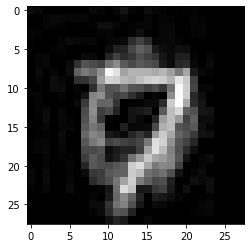

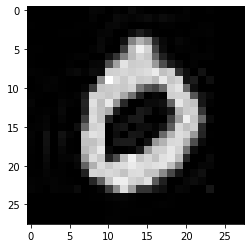

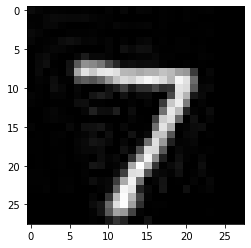

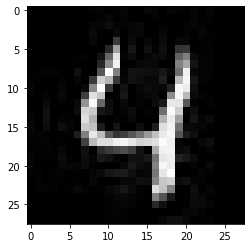

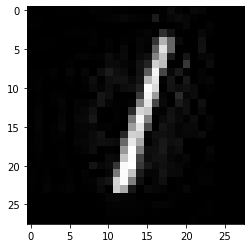


Done!

Wall time: 5.96 s


In [5]:
%%time

if __name__ == "__main__":
    main()

## Attempt using 'homemade' holograms

In this section, I've tried used the same method used above to our generated holograms. We have **10 observations**, holograms (just the real part). 

We also have a prior information about the **number of sources**, the interference patterns were created by **2 point sources** in different positions. so, we have a **overdetermined mixture**.

In [6]:
# NFM method accept just matrix positives

def resetNegativeValues(hol):
    hol_positive = np.zeros((len(hol), len(hol[0])))
    for r in range(len(hol)):
        for c in range(len(hol[0])):
            if hol[r][c] < 0:
                hol_positive[r][c] = 0;
            else:
                hol_positive[r][c] = hol[r][c]
    return hol_positive

In [7]:
import glob
import numpy as np
import scipy.io
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF

def main():
    images = []
    for path in glob.glob("mixture_dataset(2points)/*.mat"):
        images.append(np.loadtxt(path))
        
    # Limit the number of samples
    #lim = 10
    #images = images[:lim]

    print('The first figure is an example of the mixture.\n')
    plt.figure()
    plt.imshow(images[0], cmap = 'gray')

    # Reshape images to 1D arrays
    flat_images = np.array(images).reshape(len(images), -1)

    X = flat_images
    print('X (Observations): ' + str(X.shape))

    option = "ICA" # ICA, NMF, SparsePCA 
    #option = "NMF"
    #option = "SparcePCA"

    if (option == 'ICA'):

        # ICA implemented by scikit learn

        ica_model = FastICA(n_components = 2, tol = 1e-8, max_iter = 100000)
        ica_model.fit(X)

        A_ = ica_model.mixing_ # (n_features, n_components)

        A_t = A_.transpose().reshape(-1, 200, 200)
        print('Sources separated: ' + str(A_t.shape))

        for i, im in enumerate(A_t):
            cv2.imwrite("output/hol_ica_{}.jpg".format(i), im)

        dim = A_t.shape

        print('Printing sources separated by using ICA.')
        for i in range(int(dim[0])):
            plt.figure()
            plt.imshow(A_t[i][:][:], cmap = 'gray')

        print('\nDone!\n')

    elif (option == 'NMF'):

        # NMF implemented by scikit learn

        nmf_model = NMF(n_components = 2, tol = 1e-8, max_iter = 10000)
        X = resetNegativeValues(flat_images)
        nmf_model.fit(X)

        H_ = nmf_model.components_ # (n_componets, n_features)
        H_2 = H_.reshape(-1, 200, 200)
        print('Sources separated: ' + str(H_2.shape))

        for i, im in enumerate(H_2):
            cv2.imwrite("output/hol_nmf_{}.jpg".format(i), im)

        dim = H_2.shape

        print('Printing sources separated by using NMF.')
        for i in range(int(dim[0])):
            plt.figure()
            plt.imshow(H_2[i][:][:], cmap = 'gray')

        print('\nDone!\n')

    else:
        print('Unrecognized option!')

The first figure is an example of the mixture.

X (Observations): (10, 40000)


c:\users\ferna\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Sources separated: (2, 200, 200)
Printing sources separated by using ICA.

Done!

Wall time: 21 s


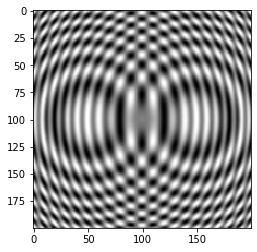

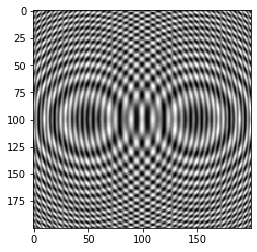

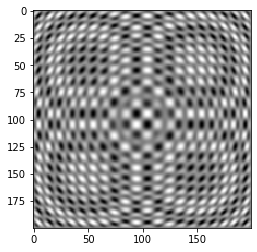

In [8]:
%%time

if __name__ == "__main__":
    main()

In [9]:
import scipy.io

# Problemes avec l'Octave pour sauvagarder en format .mat, il faut preciser le format -v7 pour etre capable de lire le
# dictionnaire (1), sinon c'est possible lire avec la bibliotheque numpy si on a seulement une image dans le fichier (2) 
# (1): hol = np.loadtxt('mixture_dataset(2points)/hologram_1.mat')
# (2): hol = scipy.io.loadmat('hologram_dataset_10_samples_2_sources.mat')

def showDatasetHologram():    
    mat_file = scipy.io.loadmat('hologram_dataset_10_samples_2_sources.mat')
    print(mat_file.keys())

    hol_dataset = mat_file['hologram_dataset']
    dim = hol_dataset.shape
    print(dim)

    for i in range(dim[2]):
        plt.figure()
        plt.imshow(hol_dataset[:,:,i], cmap = 'gray')
        plt.show()

dict_keys(['__header__', '__version__', '__globals__', 'hologram_dataset'])
(200, 200, 10)


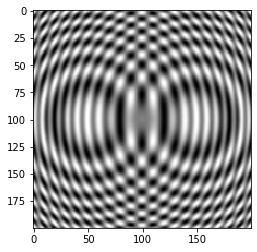

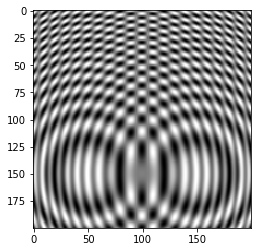

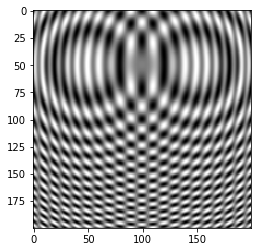

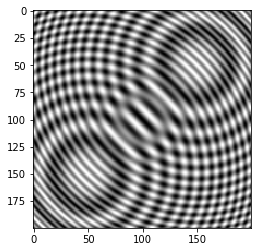

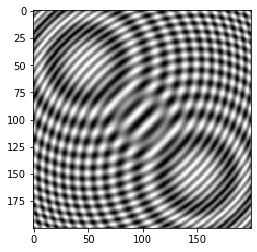

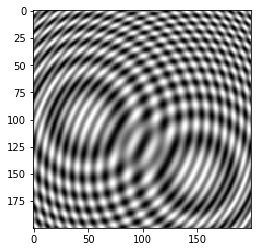

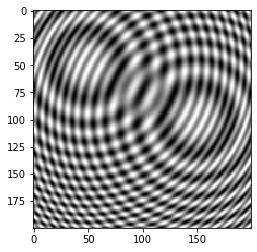

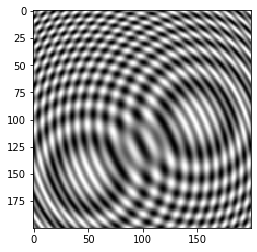

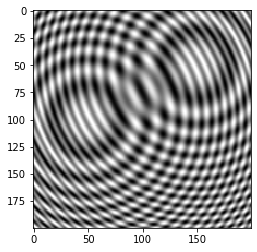

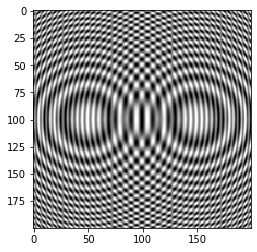

In [10]:
showDatasetHologram()

## Holograms from repository

<class 'numpy.ndarray'>
(1080, 1920, 3)


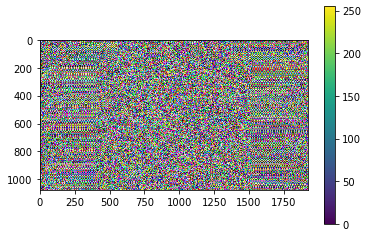

In [11]:
dice = plt.imread("C:\\Users\\ferna\\Desktop\\computerGeneratedHolography\\data\\dices1080p-AP\\dices1080p_phase.bmp")
print(type(dice))
print(dice.shape)

#plt.imshow(dice[:,:,1])
plt.imshow(dice)
plt.colorbar()
plt.show()

<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'pitch', 'wlen', 'Hol', 'zobj'])
<class 'numpy.complex128'>
(1080, 1920)


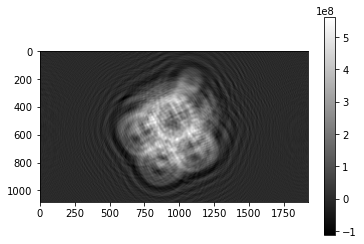

In [12]:
holDice = scipy.io.loadmat("C:\\Users\\ferna\\Desktop\\computerGeneratedHolography\\data\\2D_dice\\Hol_2D_dice.mat")
print(type(holDice))
print(holDice.keys())

holDiceHol = holDice['Hol']
print(type(holDiceHol[0,0]))
print(holDiceHol.shape)

plt.imshow(np.real(holDiceHol), cmap = 'gray')
plt.colorbar()
plt.show()

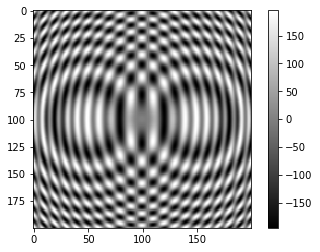

In [13]:
hol = np.loadtxt('hologram_image.mat')
#hol = scipy.io.loadmat('hologram_image.mat')

plt.imshow(hol, cmap='gray')
plt.colorbar()
plt.show()

## Brouillon

Automatically created module for IPython interactive environment

X shape: (222, 325)

Observations :


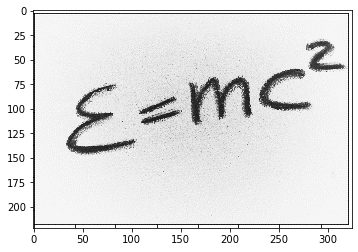


S_ shape: (222, 2)

Reconstruct image using 2 components:


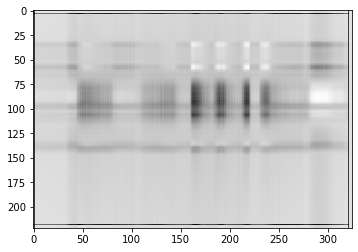


Model:
X = A x S

Estimated mixing matrix shape: (325, 2)
Wall time: 1.24 s


In [8]:
%%time

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

from sklearn.decomposition import FastICA

# #############################################################################

# Observations (X) already generated and mixing matrix (A) unknown
X = hol

X = plt.imread('emc2_original.png')
X = cv.cvtColor(X, cv.COLOR_RGB2GRAY)

print('\nX shape:', X.shape)
print('\nObservations :')
plt.imshow(X, cmap = 'gray')
plt.show()

# Compute ICA
ica = FastICA(n_components = 2, max_iter = 1000, tol = 1e-8) # n_components is the number of independent components that we want to identify
ica.fit(X)
S_ = ica.fit_transform(X)
A_ = ica.mixing_  # Get estimated mixing matrix

print('\nS_ shape:', S_.shape)

# reconstruct image with independent components (to verify how much information we lost)
hol_restored = ica.inverse_transform(S_)

print('\nReconstruct image using ' + str(S_.shape[1]) + ' components:')
plt.imshow(hol_restored, cmap = 'gray')
plt.show()

# We can `prove` that the ICA model applies by reverting the unmixing.
#assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# #############################################################################
# Plot results
print('\nModel:\nX = A x S')
print('\nEstimated mixing matrix shape:', A_.shape)

In [171]:
def calculate_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [175]:
print('PSNR between the images: ' + str(calculate_psnr(X, hol_restored)) + ' dB')

PSNR between the images: 90.89395492751225 dB


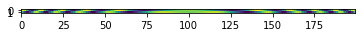

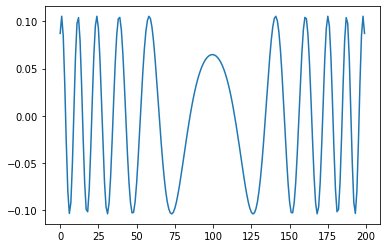

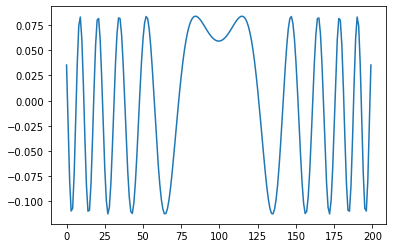

In [173]:
dim = S_.shape

plt.imshow(S_.T)
plt.show()

for i in range(dim[1]):
    plt.plot(S_[:, i])
    plt.show()

## NMF (Non-negative Matrix Factorization)

In [157]:
from sklearn.decomposition import NMF
import scipy.io
import math

### Example using images

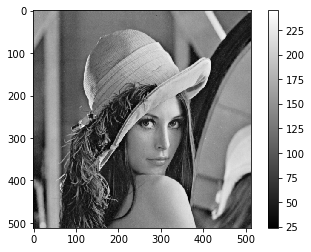

In [3]:
img = plt.imread('lena.bmp')
plt.imshow(img, cmap = 'gray')
plt.colorbar()
plt.show()

In [4]:
model_img = NMF(n_components=2, init='random', random_state=0)
W_img = model_img.fit_transform(img)
H_img = model_img.components_

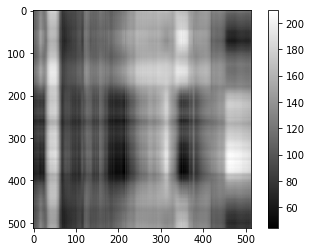

In [5]:
img2 = np.matmul(W_img, H_img)

plt.imshow(img2, cmap = 'gray')
plt.colorbar()
plt.show()

In [7]:
print('PSNR between the images: ' + str(calculate_psnr(img, img2)))

PSNR between the images: 17.11536325766161


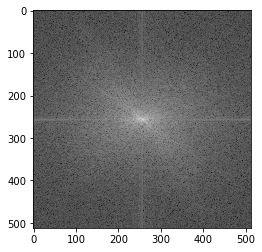

In [13]:
ft = np.fft.fft2(img)
ft2 = np.fft.fftshift(ft)
ft3 = np.fft.ifftshift(ft2)
ft4 = np.fft.ifft2(ft3)

'''
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)

plt.subplot(151), plt.imshow(img, "gray"), plt.title("Original Image")
plt.subplot(152), plt.imshow(np.log(1+np.abs(ft)), "gray"), plt.title("Spectrum")
plt.subplot(153), plt.imshow(np.log(1+np.abs(ft2)), "gray"), plt.title("Centered Spectrum")
plt.subplot(154), plt.imshow(np.log(1+np.abs(ft3)), "gray"), plt.title("Decentralized")
plt.subplot(155), plt.imshow(np.abs(ft4), "gray"), plt.title("Processed Image")
plt.show()
'''

plt.imshow(np.log(1+np.abs(ft2)), "gray")
plt.show()

In [15]:
print(img.shape)
print(ft.shape)

(512, 512)
(512, 512)


### Example using

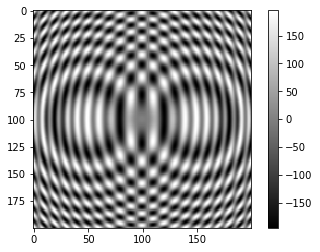

In [10]:
#hol = scipy.io.loadmat('hologram_image.mat')
hol = np.loadtxt('hologram_image.mat')

plt.imshow(hol, cmap='gray')
plt.colorbar()
plt.show()

In [10]:
hol_positive = np.zeros((len(hol), len(hol[0])))

for r in range(len(hol)):
    for c in range(len(hol[0])):
        if hol[r][c] < 0:
            hol_positive[r][c] = 0;
        else:
            hol_positive[r][c] = hol[r][c]

model_hol = NMF(n_components=2, init='random', random_state=0)
W_hol = model_hol.fit_transform(hol_positive)
H_hol = model_hol.components_

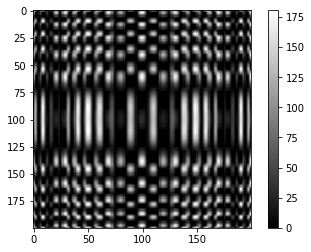

In [11]:
hol2 = np.matmul(W_hol, H_hol)

plt.imshow(hol2, cmap = 'gray')
plt.colorbar()
plt.show()

## Wigner distribution

In [23]:
from tftb.generators import fmlin
from tftb.processing import WignerVilleDistribution

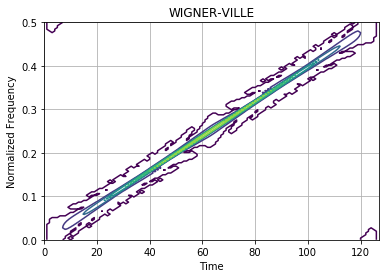

In [24]:

n_points = 128
fmin, fmax = 0.0, 0.5
signal, _ = fmlin(n_points, fmin, fmax)

'''
h = np.real(holDice['Hol'])
hf = h.reshape(-1)
hf = hf[1:1000]
'''
#print(hf.shape)
#print(type(hf[0]))

g = signal
#g = hf

wvd = WignerVilleDistribution(g)
wvd.run()
wvd.plot(kind='contour')

### Example from scikit learn

In [53]:
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

print(X)
X2 = np.matmul(W,H)
print(X2)
print(X - X2)

[[1.  1. ]
 [2.  1. ]
 [3.  1.2]
 [4.  1. ]
 [5.  0.8]
 [6.  1. ]]
[[1.00063558 0.99936347]
 [1.99965977 1.00034074]
 [2.99965485 1.20034566]
 [3.9998681  1.0001321 ]
 [5.00009002 0.79990984]
 [6.00008587 0.999914  ]]
[[-6.35579822e-04  6.36528773e-04]
 [ 3.40231372e-04 -3.40739354e-04]
 [ 3.45147253e-04 -3.45662574e-04]
 [ 1.31898319e-04 -1.32095249e-04]
 [-9.00218123e-05  9.01562192e-05]
 [-8.58722020e-05  8.60004133e-05]]


### Exemple from scikit learn

In [52]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA

X, _ = load_digits(return_X_y=True)
transformer = FastICA(n_components=7,
        random_state=0)
X_transformed = transformer.fit_transform(X)

print(X.shape)
print(X_transformed.shape)

(1797, 64)
(1797, 7)


c:\users\ferna\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
